#### - Choose one of the datasets (taxis, Geolife, etc.), select at least 10 users/vehicles and compute distributions of lengths. 
#### - Remove randomly 10% of points in each trajectory and repeat the distribution. 
#### - Do the same for 20%, 30%, … 90%. 

### How does length distribution change?

In [102]:
import skmob
import numpy as np
import osmnx as ox
import folium
import pandas as pd
import geopandas as gpd
import haversine as hs
import matplotlib.pyplot as plt
from skmob.preprocessing import filtering

from shapely.geometry import Point,MultiPoint, Polygon
from random import random, sample
import random
from skmob.preprocessing import compression
from skmob.measures.individual import distance_straight_line

In [68]:
def distributions(df, driver_chosen, percentage):
    
    #Retrieving portion of Dataframe regarding requested driver
    driver = df[df["uid"] == driver_chosen]
    
    #Sampling driver's Dataset RANDOMLY (with a random_state for replication purposes)
    driver = driver.sample(frac=percentage/100,random_state=42).sort_values(by = "datetime")
    
    #List of distances of sampled dataset
    distances_driver = []
    for i in range(len(driver)-1):
        dist = hs.haversine((driver.iloc[i].lat,driver.iloc[i].lng),
                            (driver.iloc[i+1].lat,driver.iloc[i+1].lng))
        distances_driver.append(dist)
    
    #Preparing Axes to plot
    x = [i for i in range(len(distances_driver))] # X axes = Samples
    y = sorted(distances_driver, reverse=True) # Y axes = Distances
    
    #Plotting
    res = plt.plot(x, y, color = "#46FF00")
    plt.ylabel("Distance in KMs")
    plt.title(f"Distribution of Distances - Sample {percentage}%")
    
    return res, distances_driver

In [69]:
# Plotting distributions of a single character by also generating lists to be used for BoxPlots
def driver_plots(df, driver):
    
    #Preparing plot structure
    fig = plt.figure(figsize=(20,20), edgecolor = "black",facecolor='mintcream') 
    fig_dims = (5, 2)
    
    distances_lists = []
    cont=100
    for i in range(5):
        for j in range(2):

            plt.subplot2grid(fig_dims, (i, j))
            x,y = distributions(df, driver ,cont)
            distances_lists.append(y)
        
            cont-=10
            
    return distances_lists

# Dataset Preprocessing

In [57]:
# create a TrajDataFrame from a dataset of trajectories 
taxi = skmob.TrajDataFrame(
    pd.read_csv("C:/Users/daddu/Downloads/cabs.csv.gz", 
    compression='gzip', parse_dates = ['timestamp'], 
    date_parser=lambda x: pd.to_datetime(x, unit='s')), longitude='lon', 
    datetime='timestamp', user_id='driver').sort_values(by=['uid', 'datetime'])

In [58]:
print(f"There are {len(taxi.uid.unique())} Taxi drivers in this Dataset\n")
taxi.head()

There are 536 Taxi drivers in this Dataset



,uid,lat,lng,occupied,datetime
8967902,abboip,37.75153,-122.39447,0,2008-05-17 14:12:10
8967901,abboip,37.75149,-122.39447,0,2008-05-17 14:13:34
8967900,abboip,37.75149,-122.39447,0,2008-05-17 14:14:34
8967899,abboip,37.75149,-122.39446,0,2008-05-17 14:15:35
8967898,abboip,37.75144,-122.39449,0,2008-05-17 14:41:43


In [59]:
#Computing list of the first 10 distinct drivers
random.seed(41)
drivers = sample(list(pd.unique(taxi.uid.values)),10)
print(drivers)

['ogijtri', 'isfikti', 'eybyay', 'ejesbay', 'ogofvoit', 'igvidth', 'ifefrof', 'ogjoch', 'abwecnij', 'icagpony']


In [100]:
#DF containing only 10 drivers data
taxi_10s = taxi.apply(lambda row: row[taxi['uid'].isin(drivers)])
print(f"Length Taxi Dataset : \t\t{len(taxi)} samples")
print(f"Length Taxi Dataset Reduced: \t{len(taxi_10)} samples")

Length Taxi Dataset : 		11219955 samples
Length Taxi Dataset Reduced: 	228011 samples


In [103]:
#Filtering abnormal speeds
taxi_10 = filtering.filter(taxi_10s, max_speed_kmh=250.0)
print('Number of records:\t%s'%len(taxi_10))
print('Filtered points:\t%s'%(len(taxi_10s) - len(taxi_10)))

Number of records:	227432
Filtered points:	579


## Plotting Map

In [104]:
map_f = taxi.plot_trajectory(zoom=11, opacity=0.5) 
map_f

C:\Users\daddu\anaconda3\envs\skmob\lib\site-packages\skmob\core\trajectorydataframe.py:569: UserWarning: Only the trajectories of the first 10 users will be plotted. Use the argument `max_users` to specify the desired number of users, or filter the TrajDataFrame.
  return plot.plot_trajectory(self, map_f=map_f, max_users=max_users, max_points=max_points, style_function=style_function,
C:\Users\daddu\anaconda3\envs\skmob\lib\site-packages\skmob\core\trajectorydataframe.py:569: UserWarning: If necessary, trajectories will be down-sampled to have at most `max_points` points. To avoid this, specify `max_points=None`.
  return plot.plot_trajectory(self, map_f=map_f, max_users=max_users, max_points=max_points, style_function=style_function,


How is it possible to see there are *significantly* more points in the middle area of **San Francisco**, which leads us to have a kind of a **Normal Distribuion** of points with compact tails (w.r.t. geographical reasoning).

This mostly means that by picking **random samples** of the points, we are more likely to pick central and discard the ones in the suburbs.

We are now going to iteratively sample the data of 10 different Taxi drivers starting from the whole amout of rows and reducing it to 10% of samples, with steps of 10% with respect of the entire dataset at every step.

Then we are going to plot **distributions** with respect of **Lenghts** between each pair of consegutive points and see if there are major changes in the distributions by plotting **Histograms** and **Boxplots**.


# 
# First UID Distributions Plot and Box Plot

In [105]:
print(f"Taxi Driver: \t{drivers[0]}")
dist = len(taxi_10[taxi_10["uid"] == drivers[0]])
print(f"N° of rows: \t{dist}")

Taxi Driver: 	ogijtri
N° of rows: 	24913


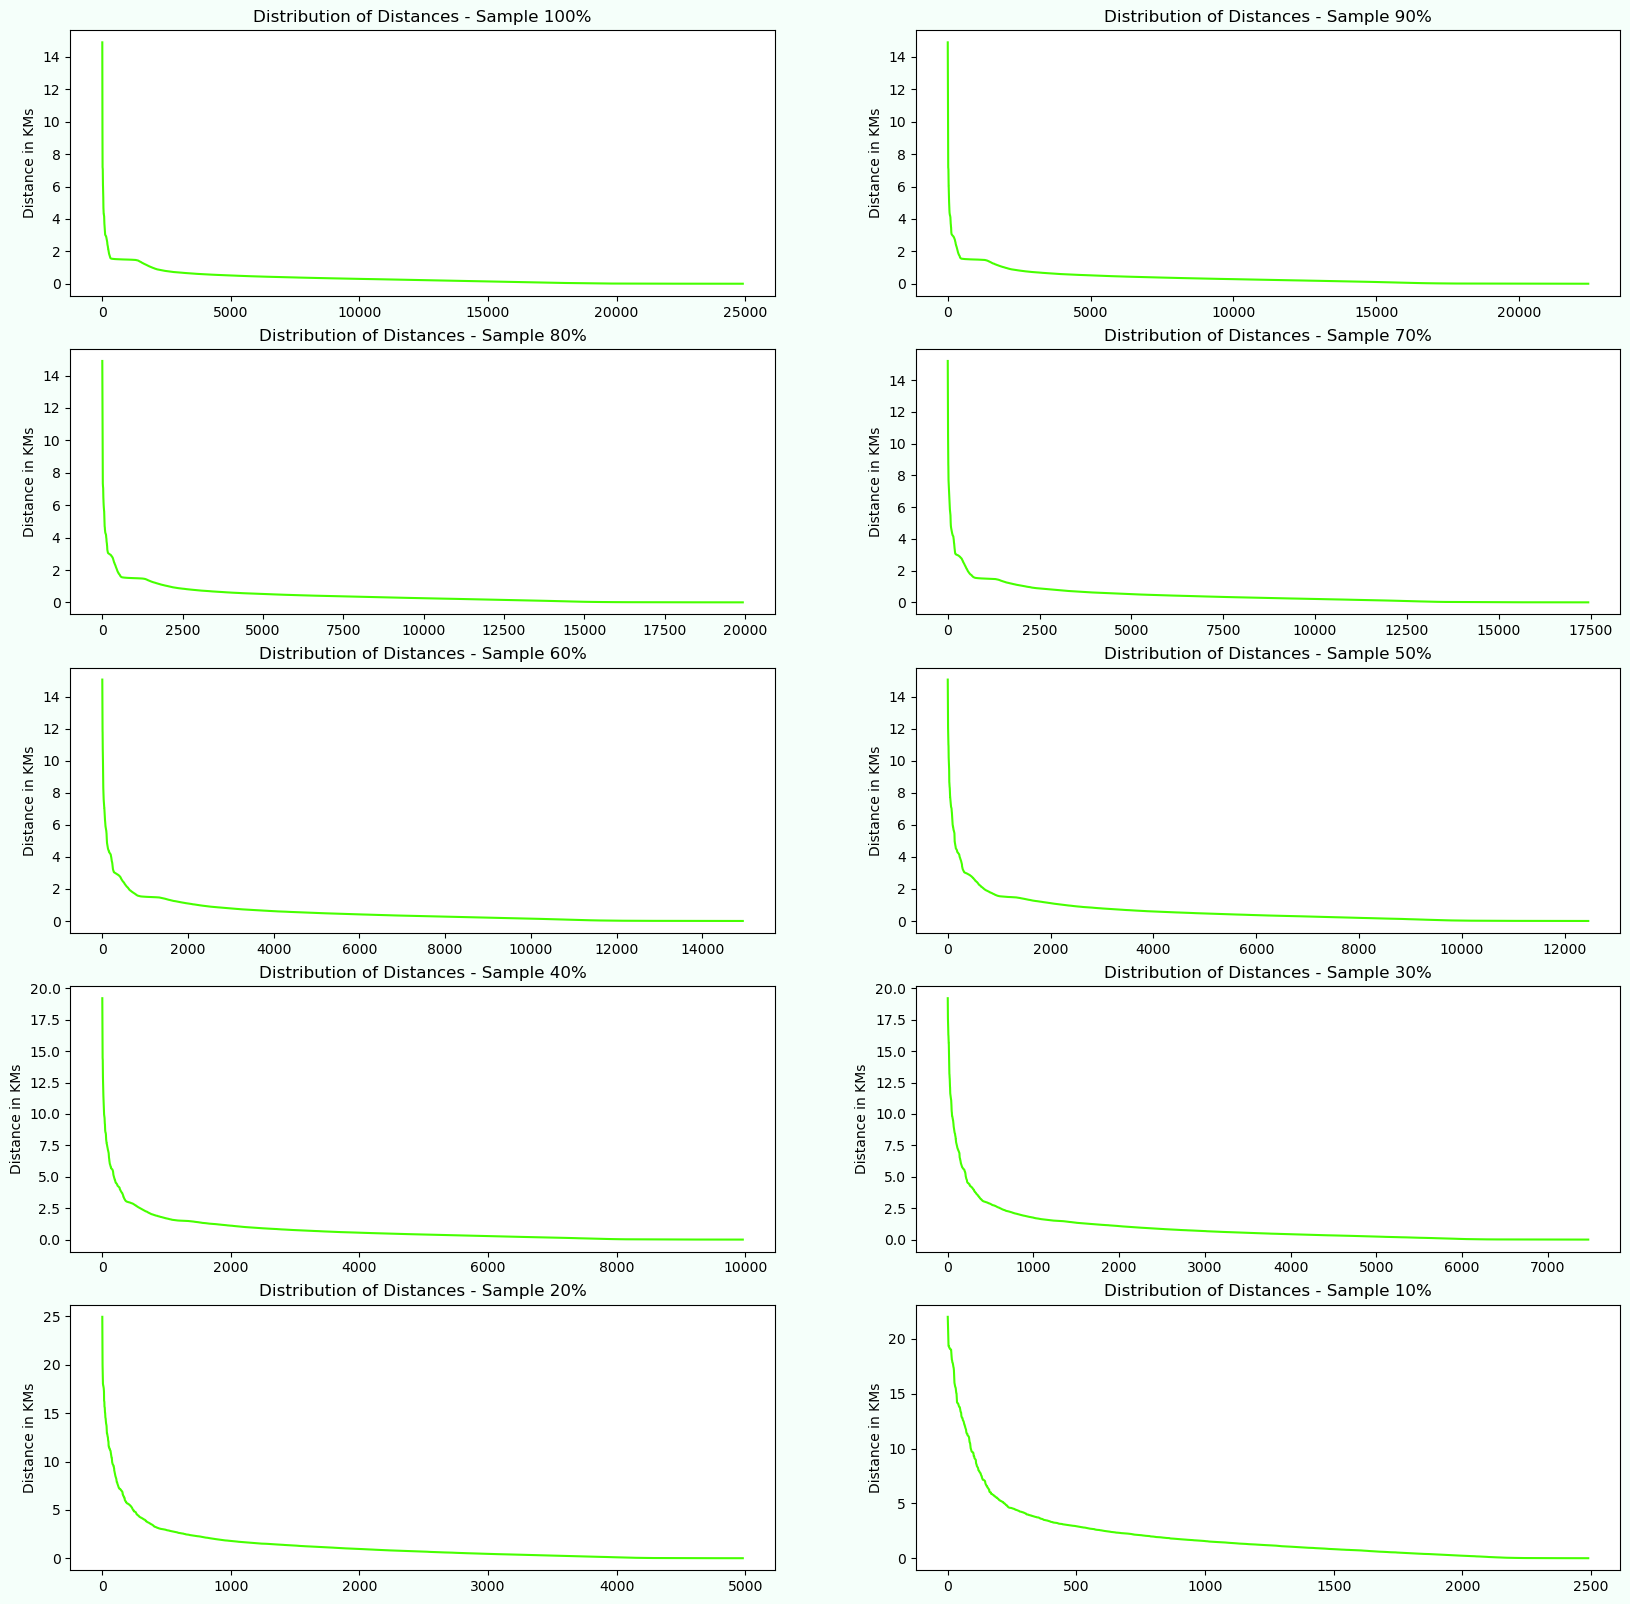

In [106]:
plot = driver_plots(taxi_10,drivers[0])

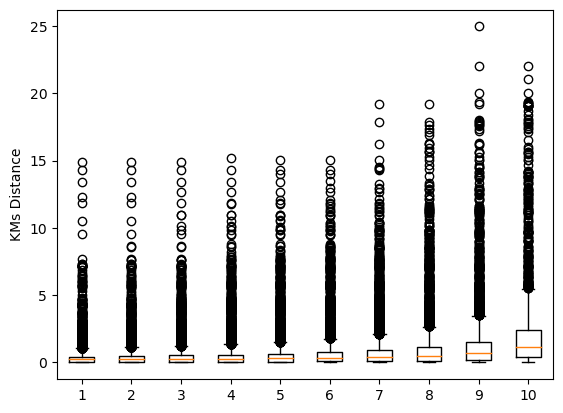

In [107]:
# Boxplots from 100% to 10% samples
plt.boxplot(plot)
plt.ylabel("KMs Distance")
plt.show()

# Second UID Distributions Plot and Box Plot

In [108]:
print(f"Taxi Driver: \t{drivers[1]}")
dist = len(taxi_10[taxi_10["uid"] == drivers[1]])
print(f"N° of rows: \t{dist}")

Taxi Driver: 	isfikti
N° of rows: 	23459


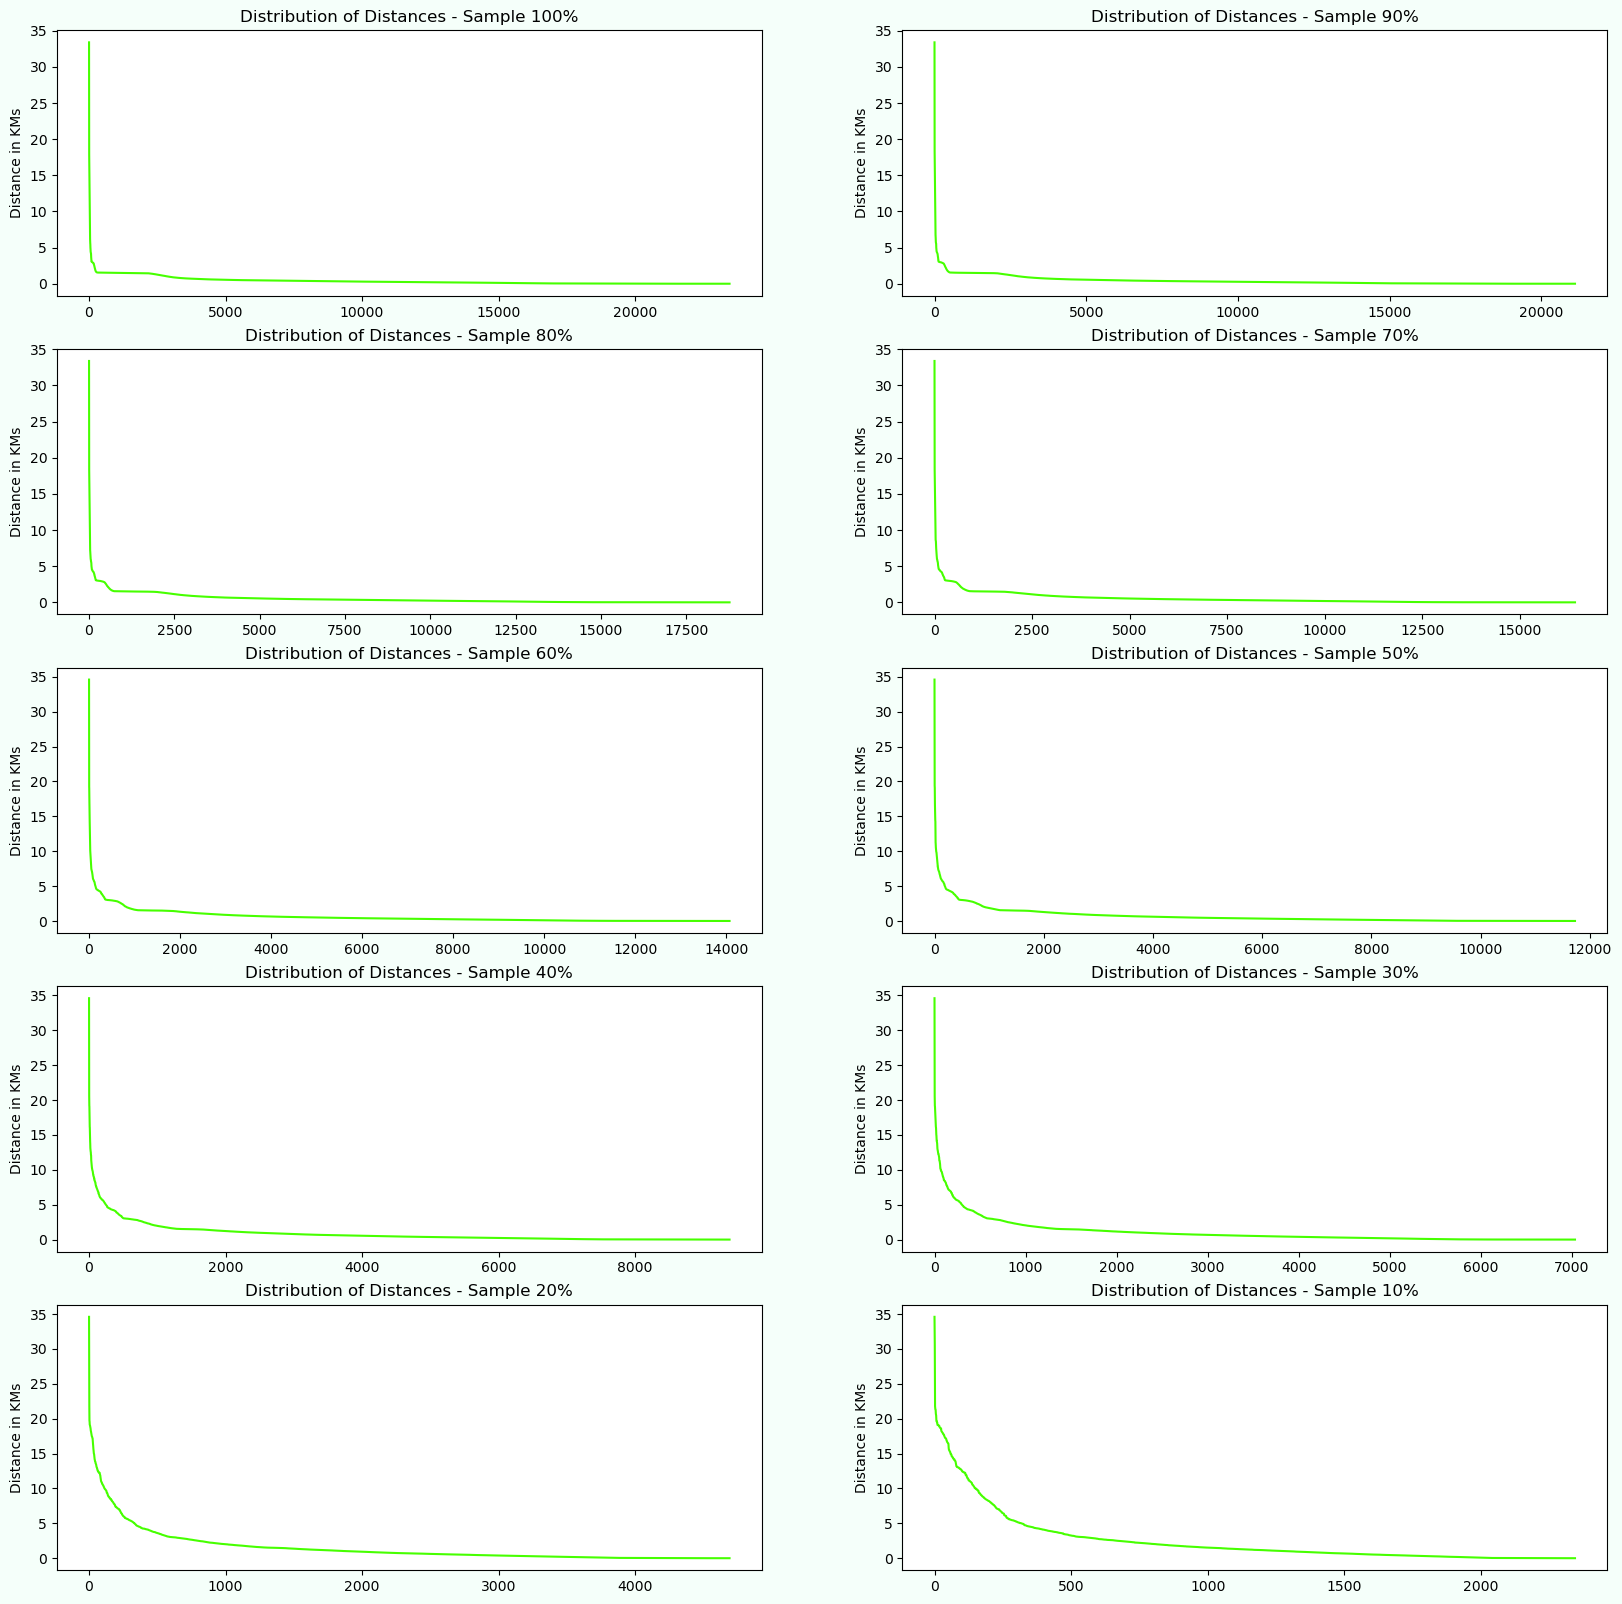

In [109]:
plot = driver_plots(taxi_10,drivers[1])

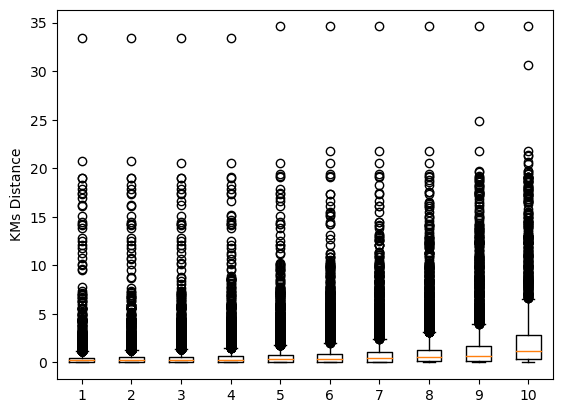

In [110]:
# Boxplots from 100% to 10% samples
plt.boxplot(plot)
plt.ylabel("KMs Distance")
plt.show()

# Third UID Distributions Plot and Box Plot

In [111]:
print(f"Taxi Driver: \t{drivers[2]}")
dist = len(taxi_10[taxi_10["uid"] == drivers[2]])
print(f"N° of rows: \t{dist}")

Taxi Driver: 	eybyay
N° of rows: 	27538


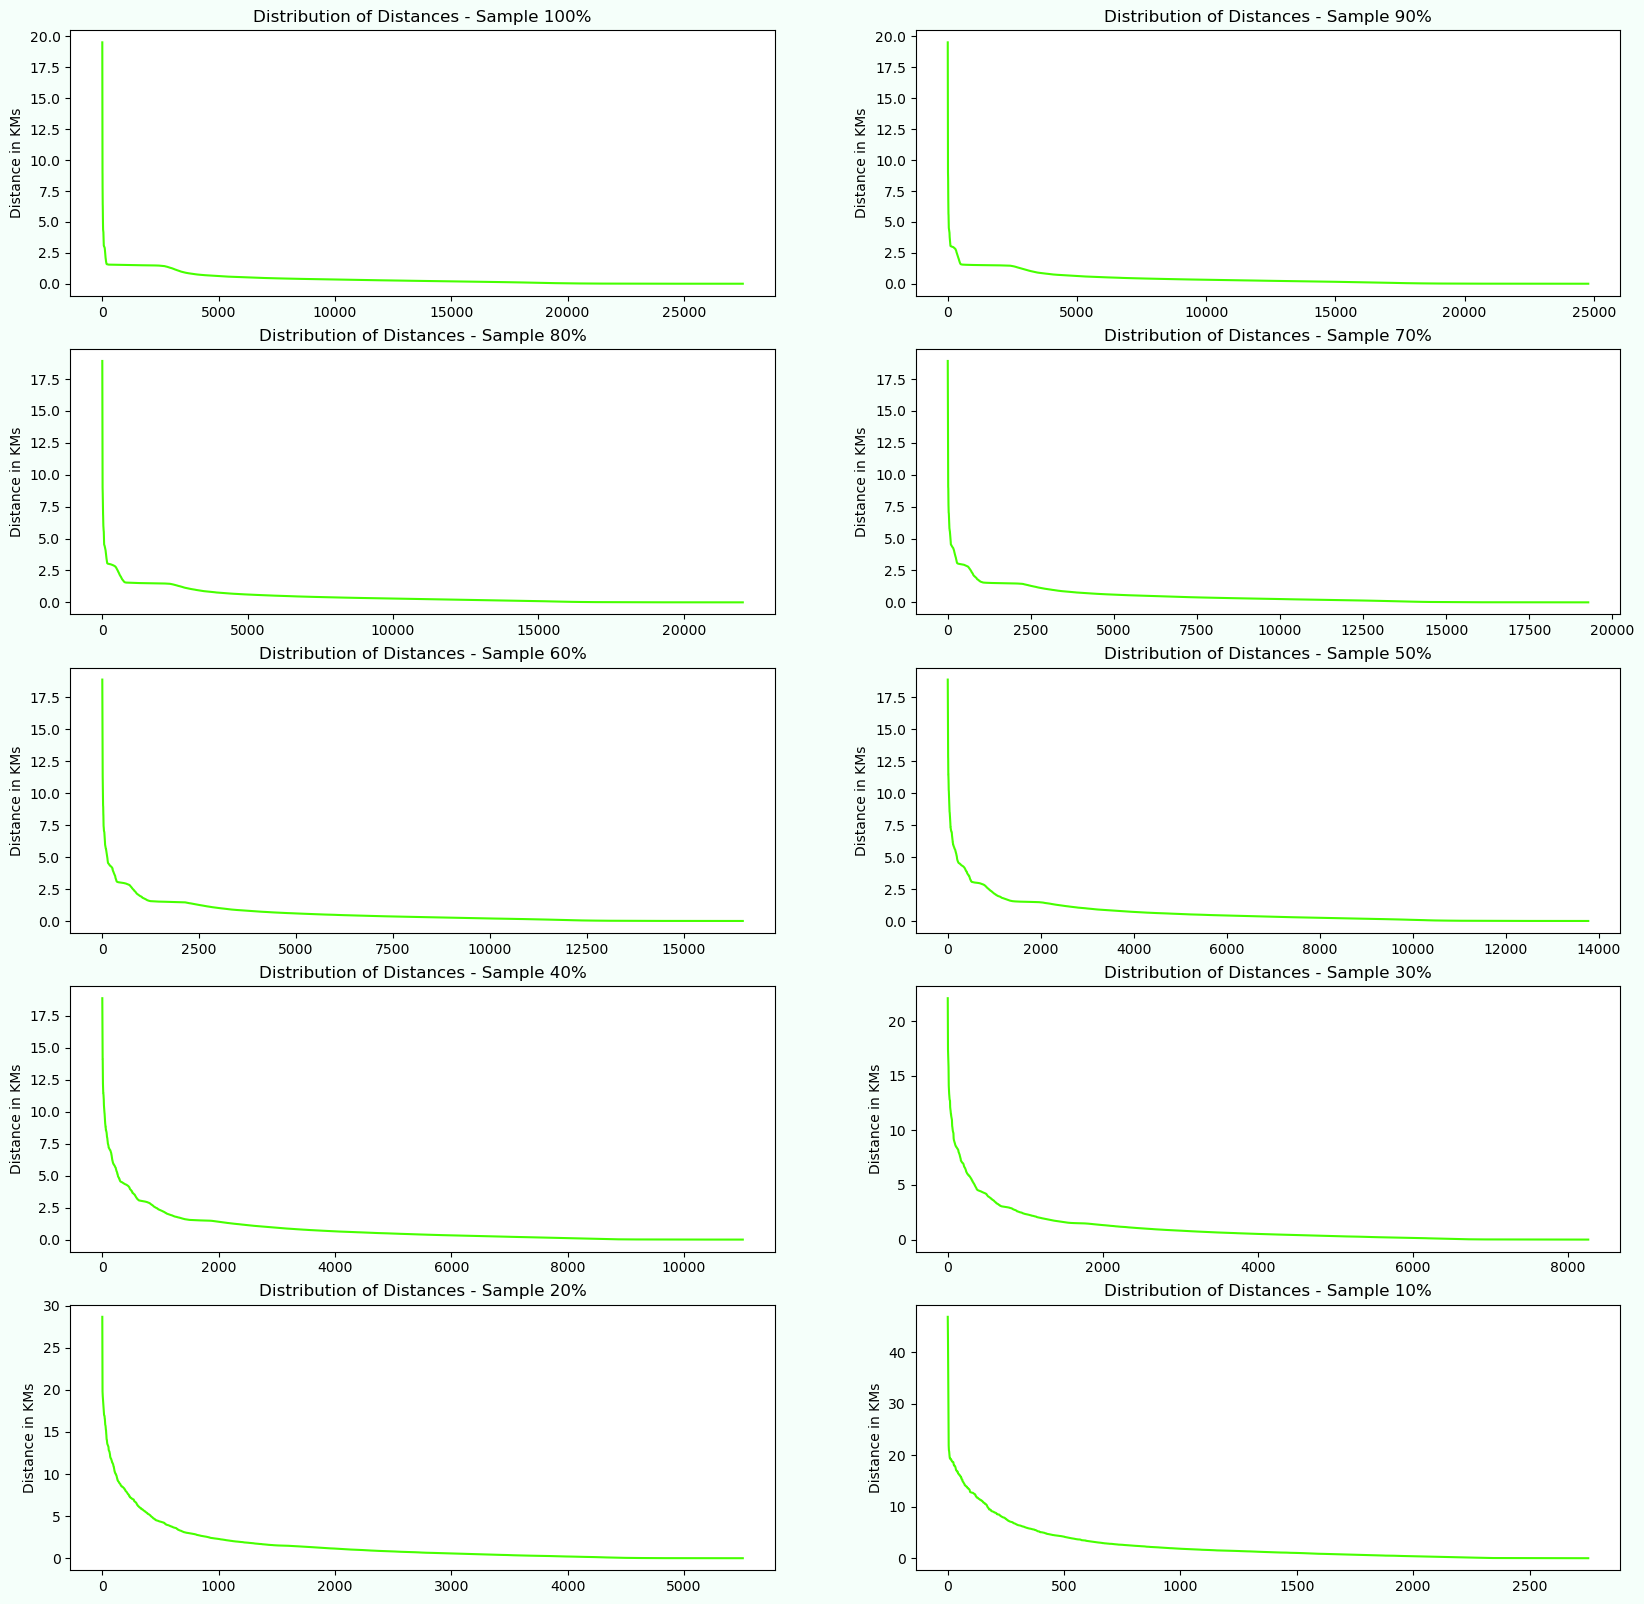

In [112]:
plot = driver_plots(taxi_10,drivers[2])

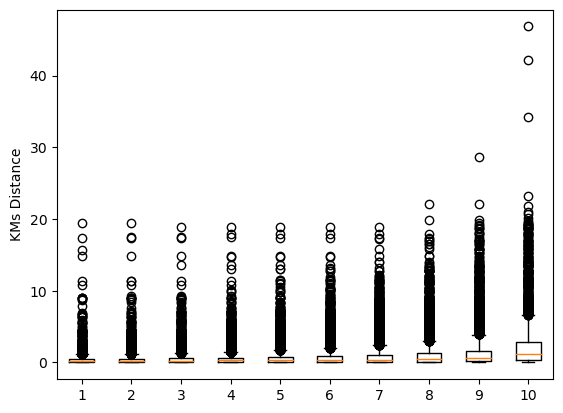

In [113]:
# Boxplots from 100% to 10% samples
plt.boxplot(plot)
plt.ylabel("KMs Distance")
plt.show()

# Forth UID Distributions Plot and Box Plot

In [114]:
print(f"Taxi Driver: \t{drivers[3]}")
dist = len(taxi_10[taxi_10["uid"] == drivers[3]])
print(f"N° of rows: \t{dist}")

Taxi Driver: 	ejesbay
N° of rows: 	21274


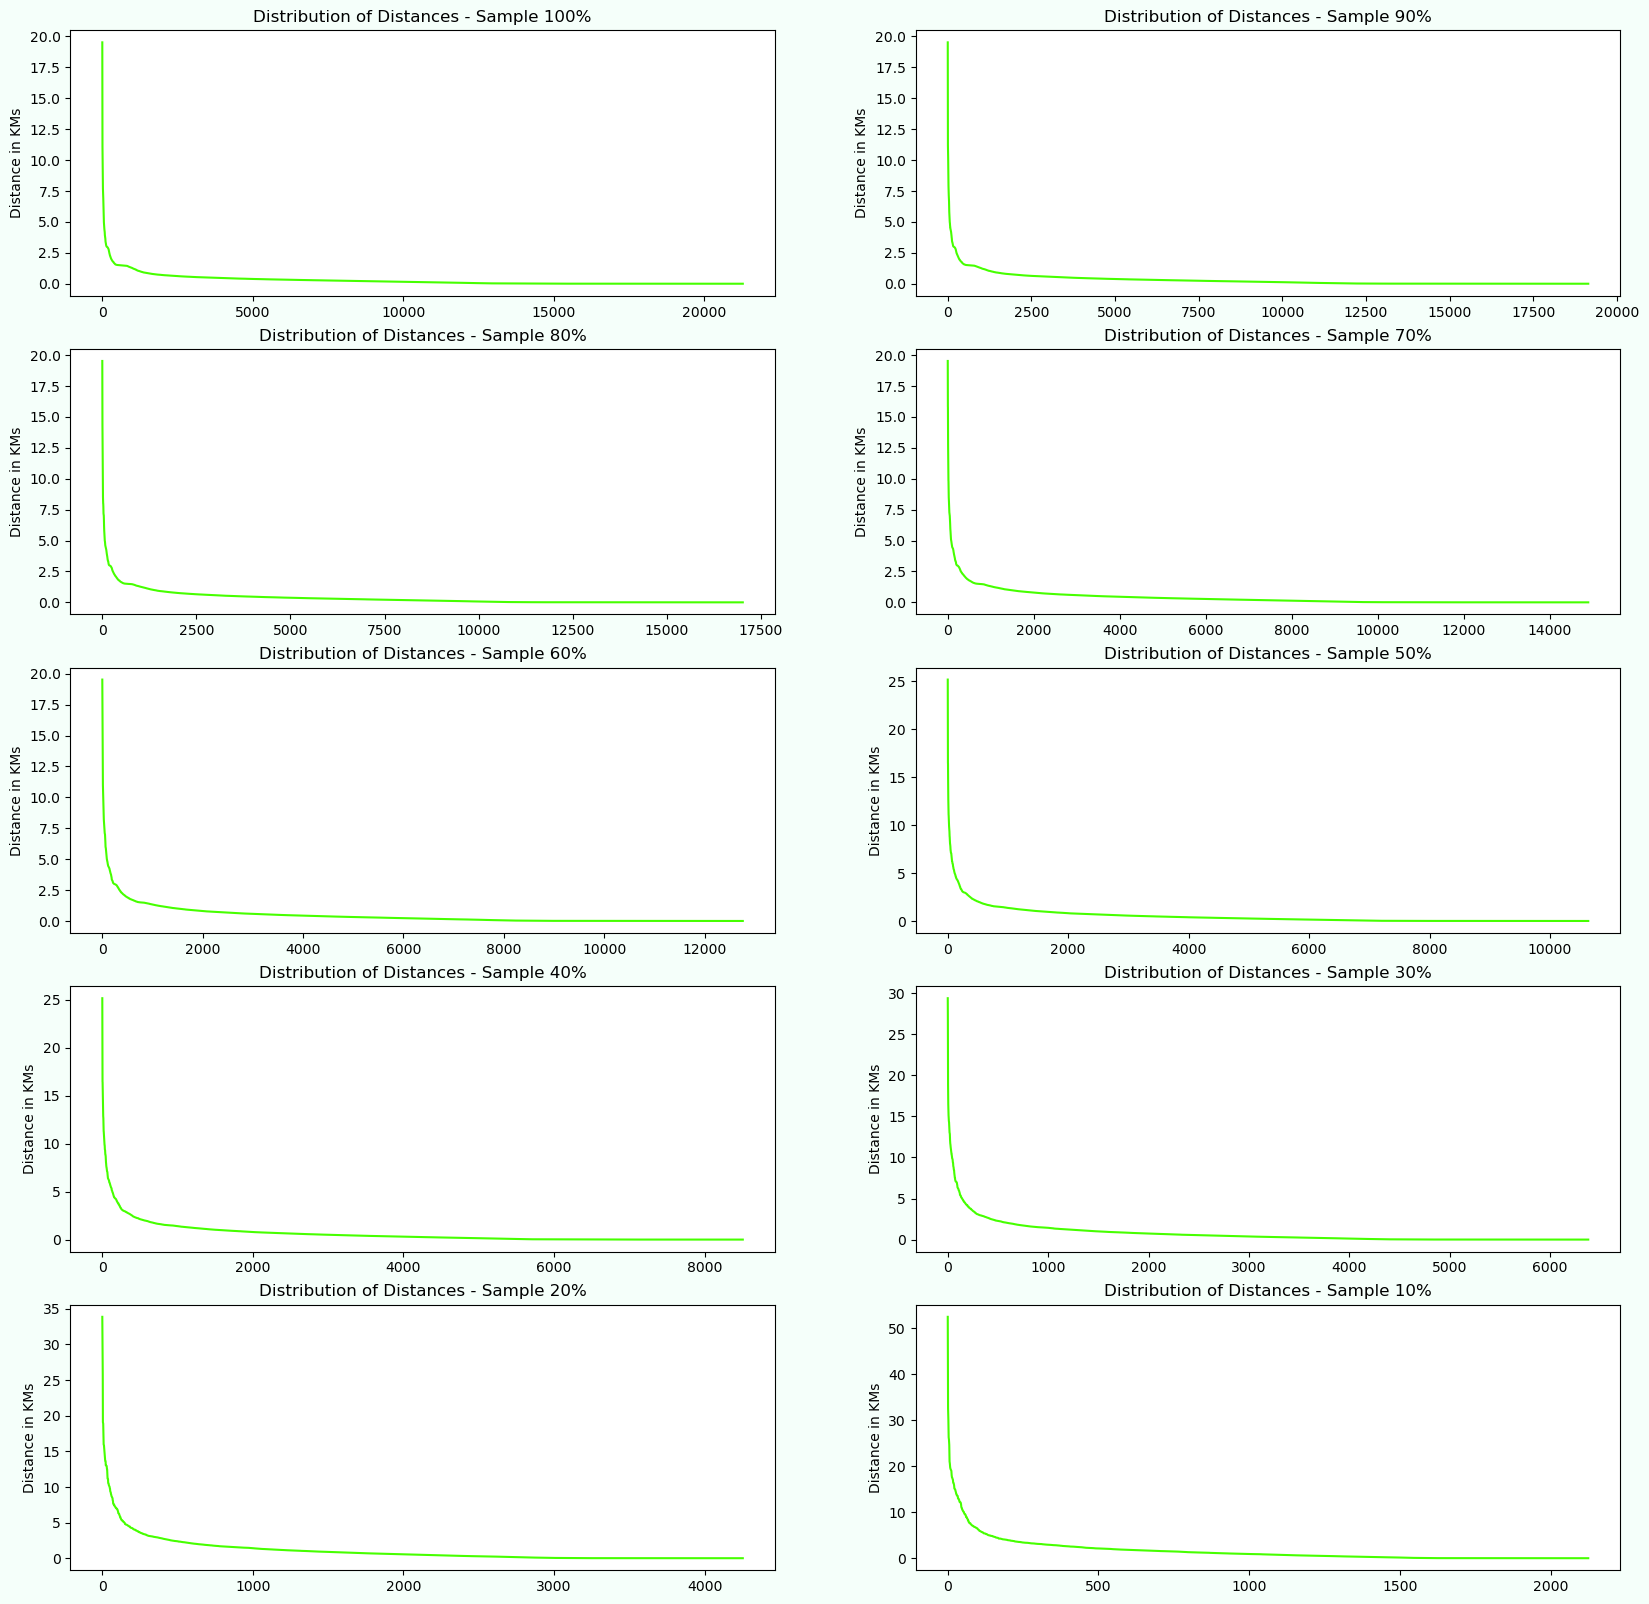

In [115]:
plot = driver_plots(taxi_10,drivers[3])

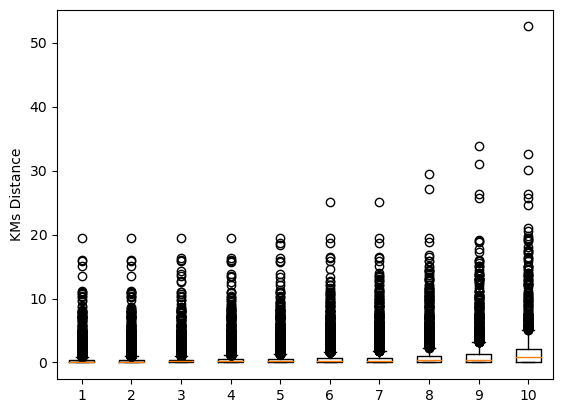

In [116]:
# Boxplots from 100% to 10% samples
plt.boxplot(plot)
plt.ylabel("KMs Distance")
plt.show()

# Fifth UID Distributions Plot and Box Plot

In [117]:
print(f"Taxi Driver: \t{drivers[4]}")
dist = len(taxi_10[taxi_10["uid"] == drivers[4]])
print(f"N° of rows: \t{dist}")

Taxi Driver: 	ogofvoit
N° of rows: 	13234


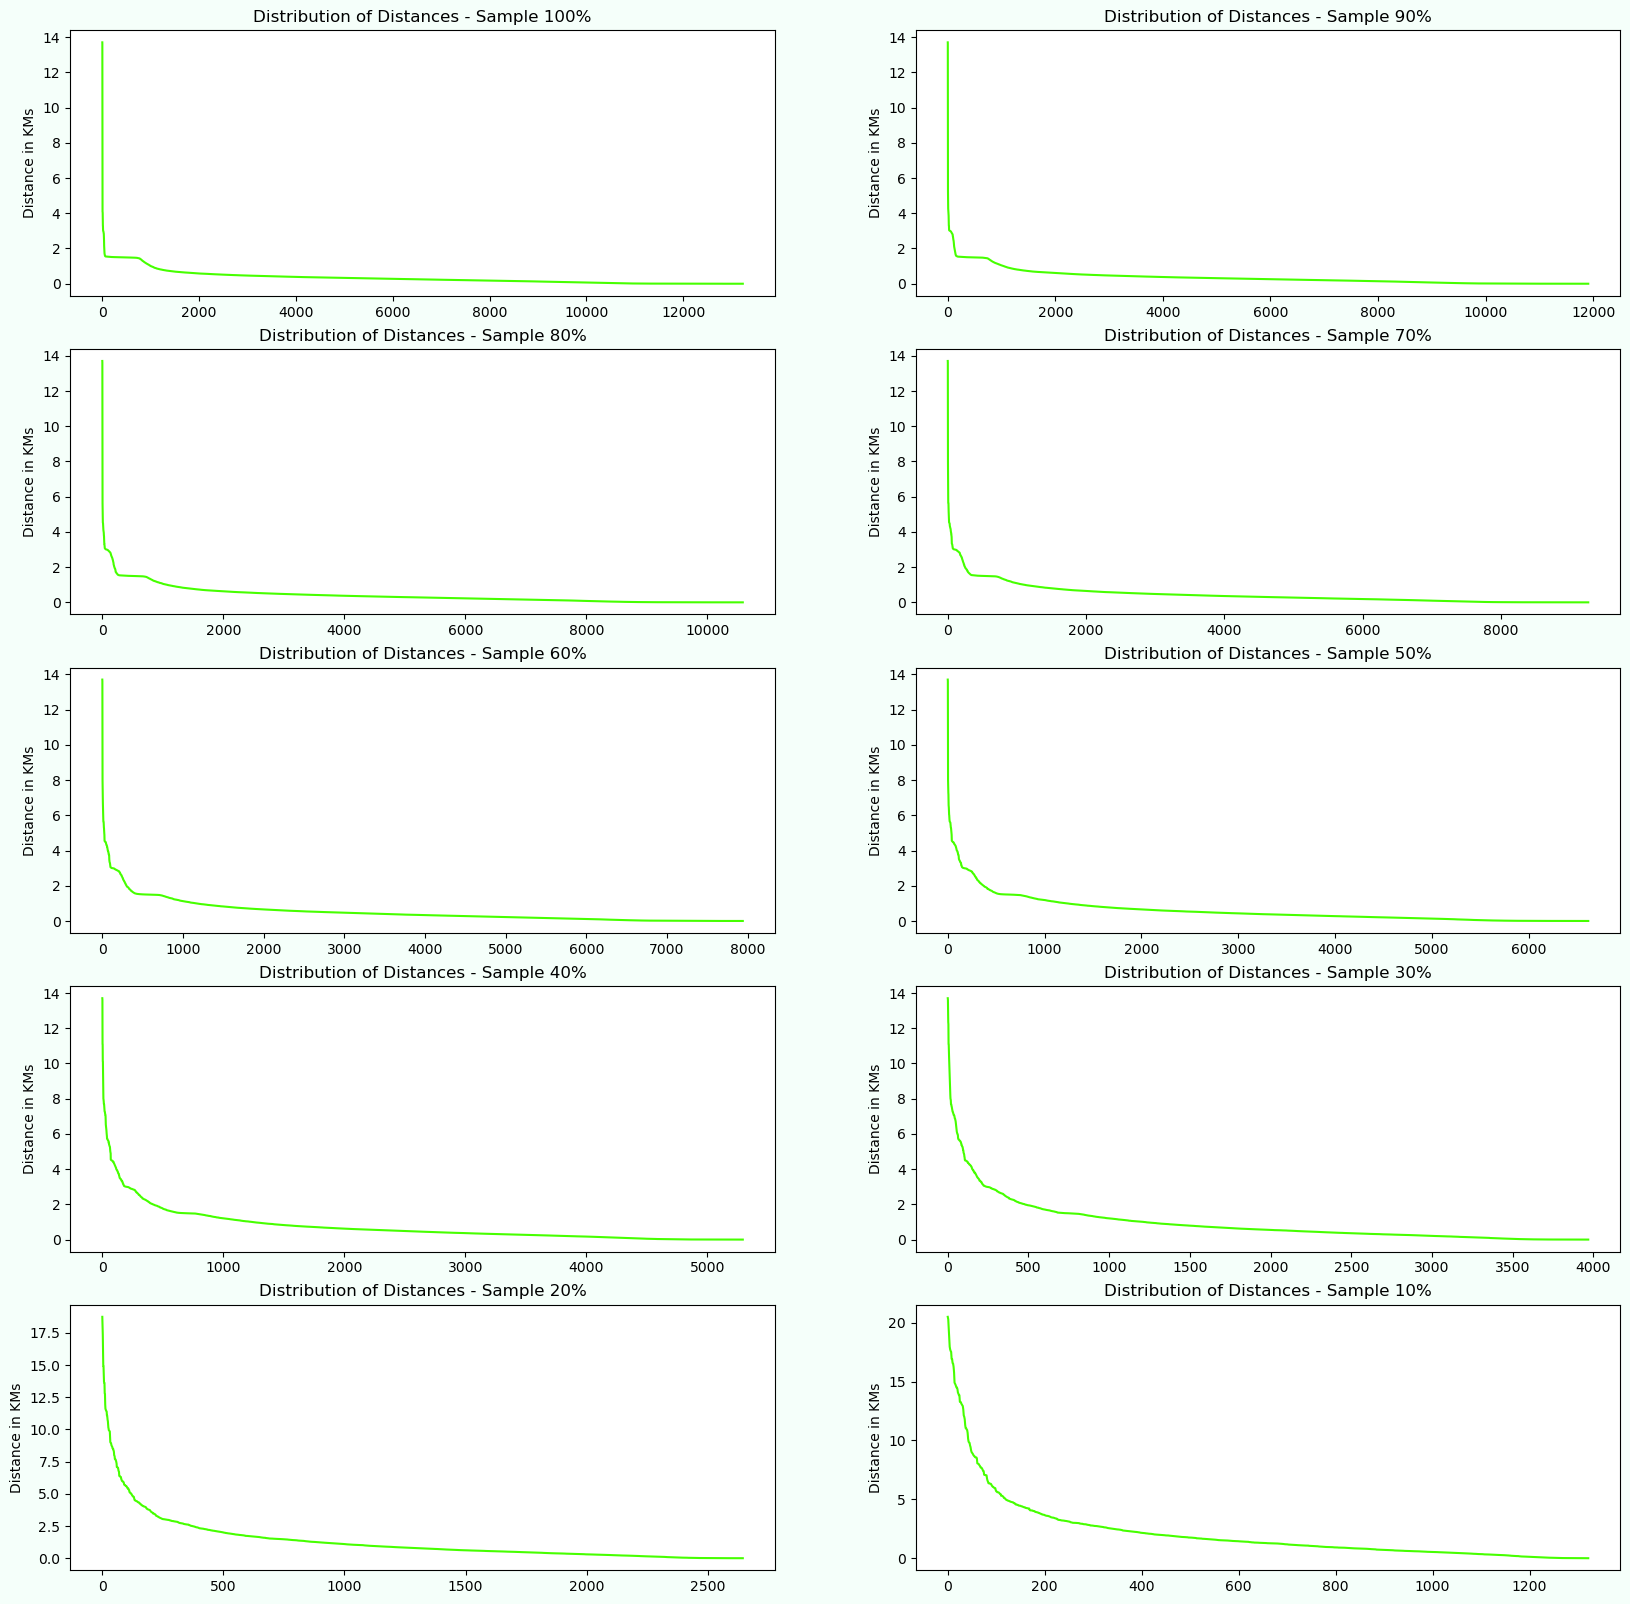

In [118]:
plot = driver_plots(taxi_10,drivers[4])

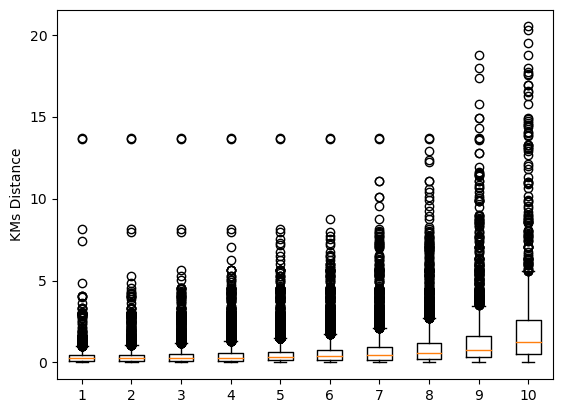

In [119]:
# Boxplots from 100% to 10% samples
plt.boxplot(plot)
plt.ylabel("KMs Distance")
plt.show()

# Sixth UID Distributions Plot and Box Plot

In [120]:
print(f"Taxi Driver: \t{drivers[5]}")
dist = len(taxi_10[taxi_10["uid"] == drivers[5]])
print(f"N° of rows: \t{dist}")

Taxi Driver: 	igvidth
N° of rows: 	26340


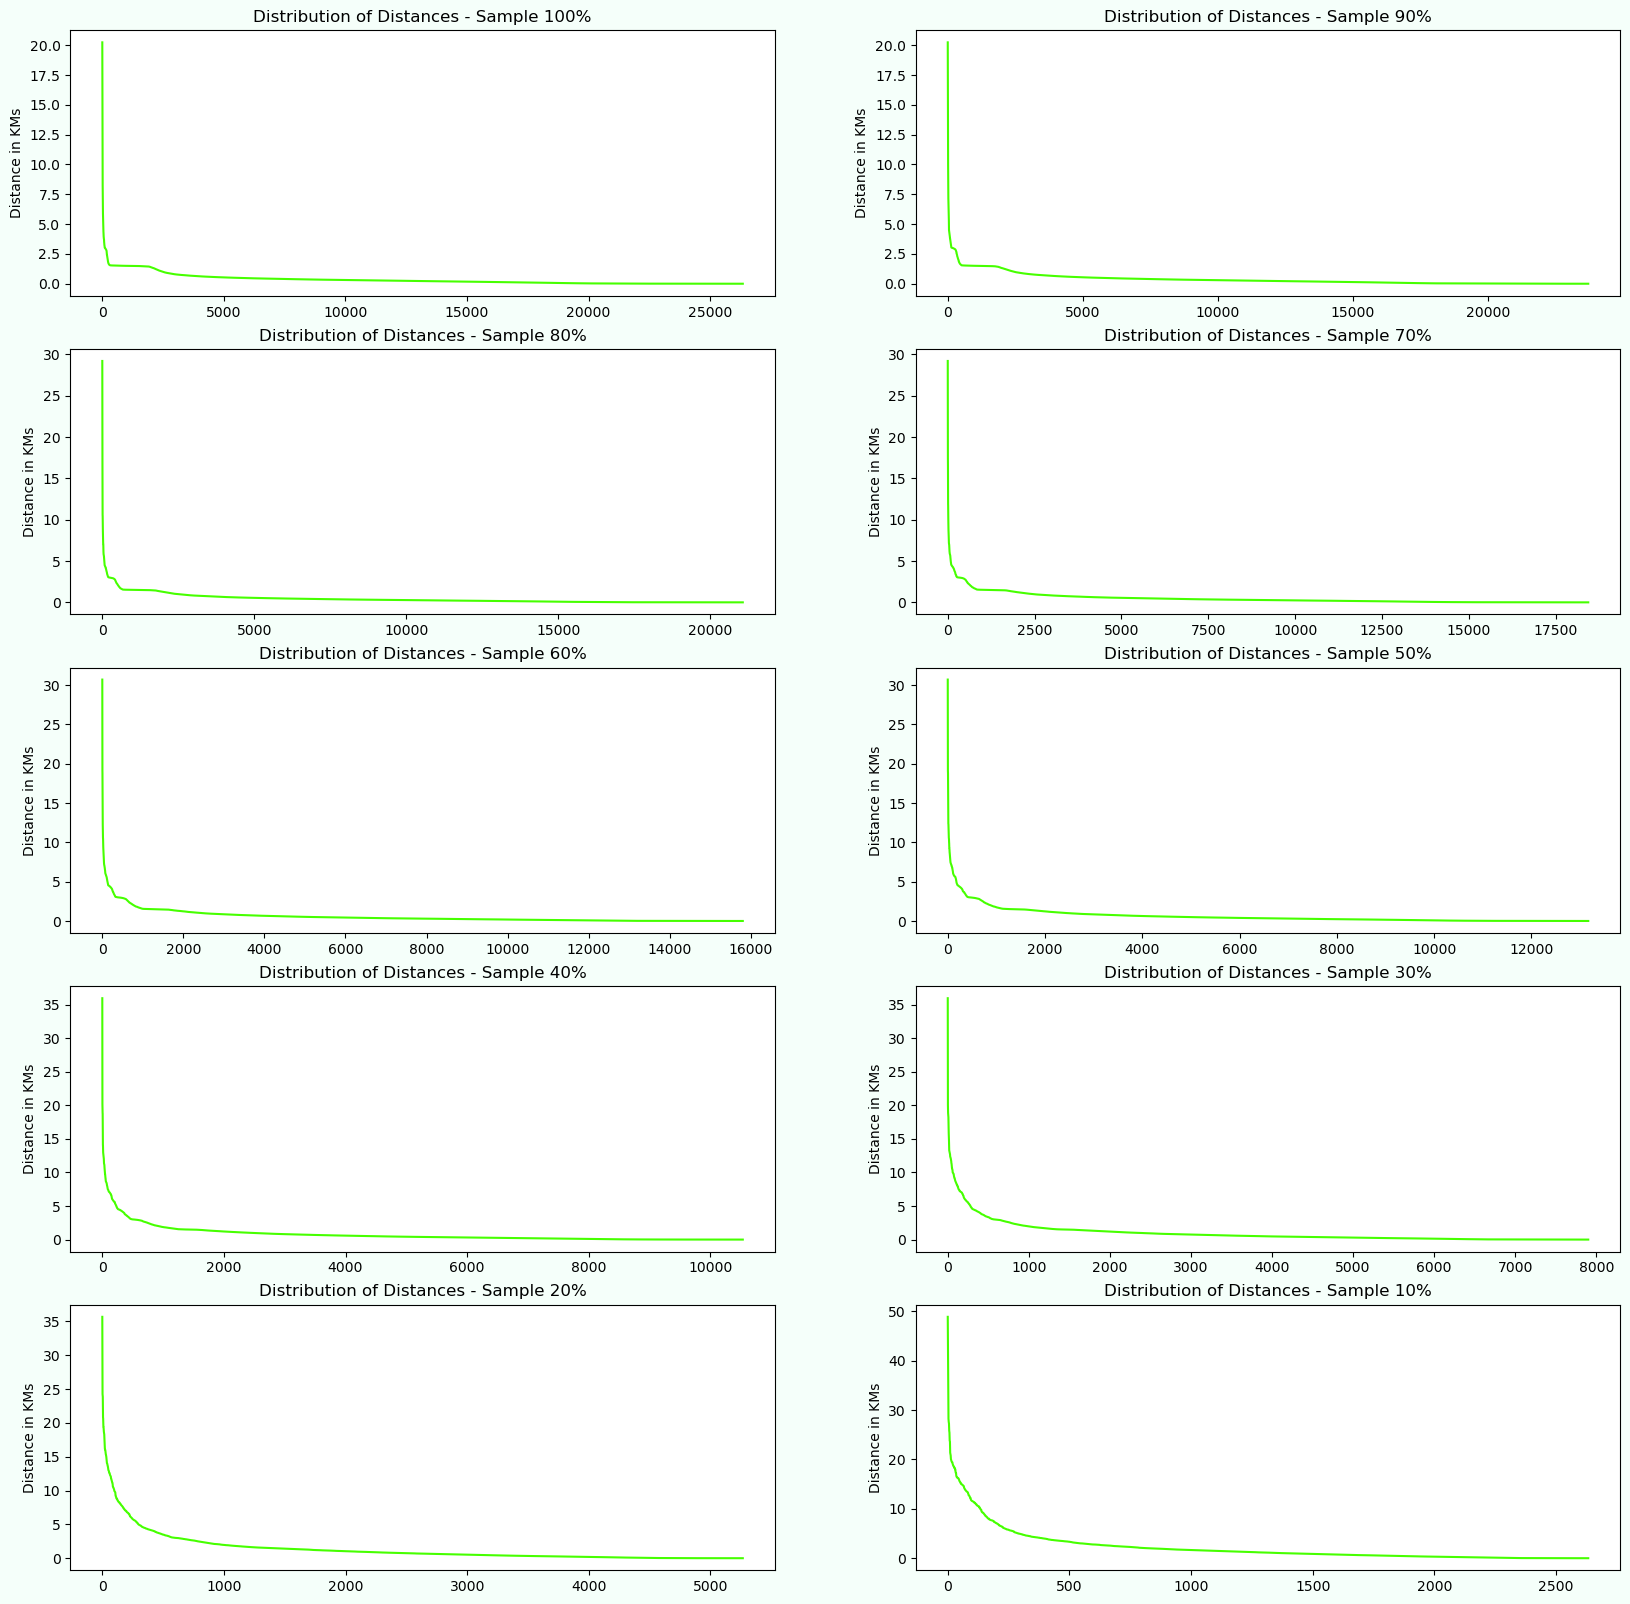

In [121]:
plot = driver_plots(taxi_10,drivers[5])

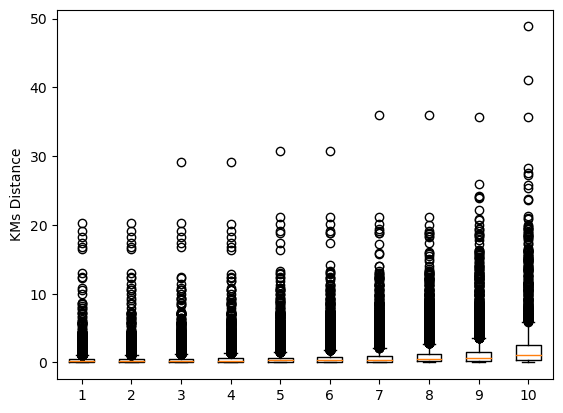

In [122]:
# Boxplots from 100% to 10% samples
plt.boxplot(plot)
plt.ylabel("KMs Distance")
plt.show()

# Seventh UID Distributions Plot and Box Plot

In [123]:
print(f"Taxi Driver: \t{drivers[6]}")
dist = len(taxi_10[taxi_10["uid"] == drivers[6]])
print(f"N° of rows: \t{dist}")

Taxi Driver: 	ifefrof
N° of rows: 	15115


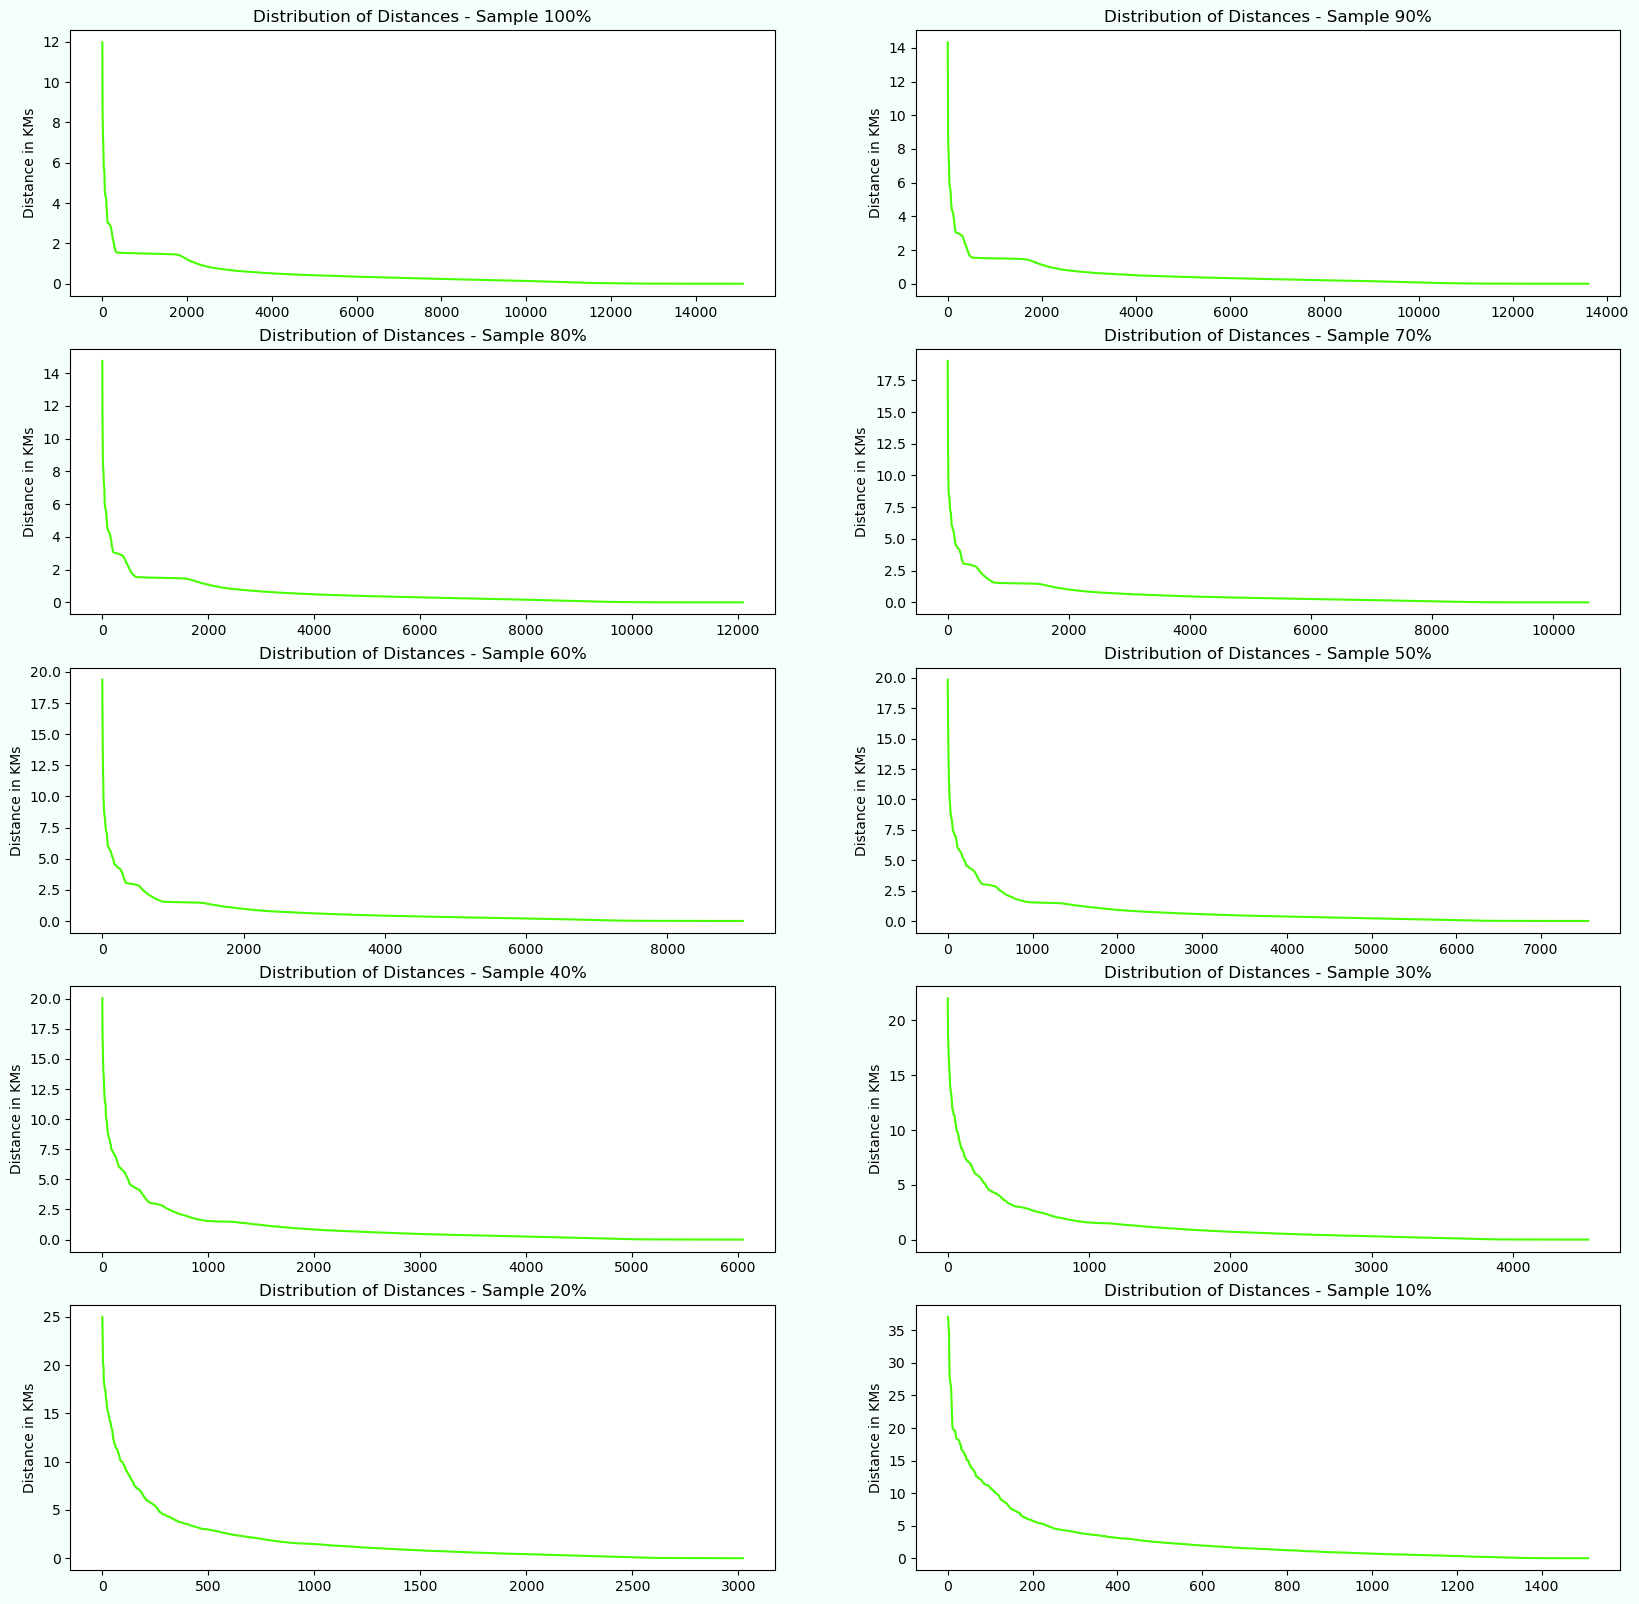

In [124]:
plot = driver_plots(taxi_10,drivers[6])

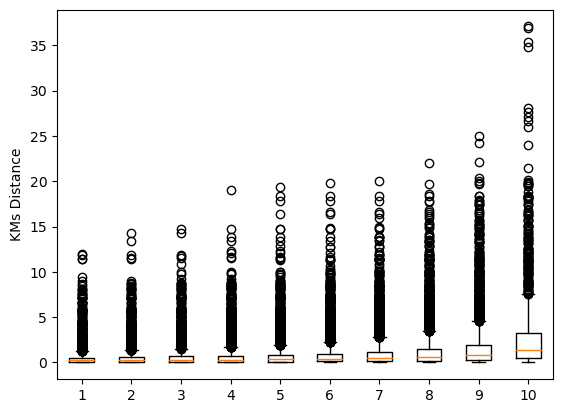

In [125]:
# Boxplots from 100% to 10% samples
plt.boxplot(plot)
plt.ylabel("KMs Distance")
plt.show()

# Eighth UID Distributions Plot and Box Plot

In [126]:
print(f"Taxi Driver: \t{drivers[7]}")
dist = len(taxi_10[taxi_10["uid"] == drivers[7]])
print(f"N° of rows: \t{dist}")

Taxi Driver: 	ogjoch
N° of rows: 	24522


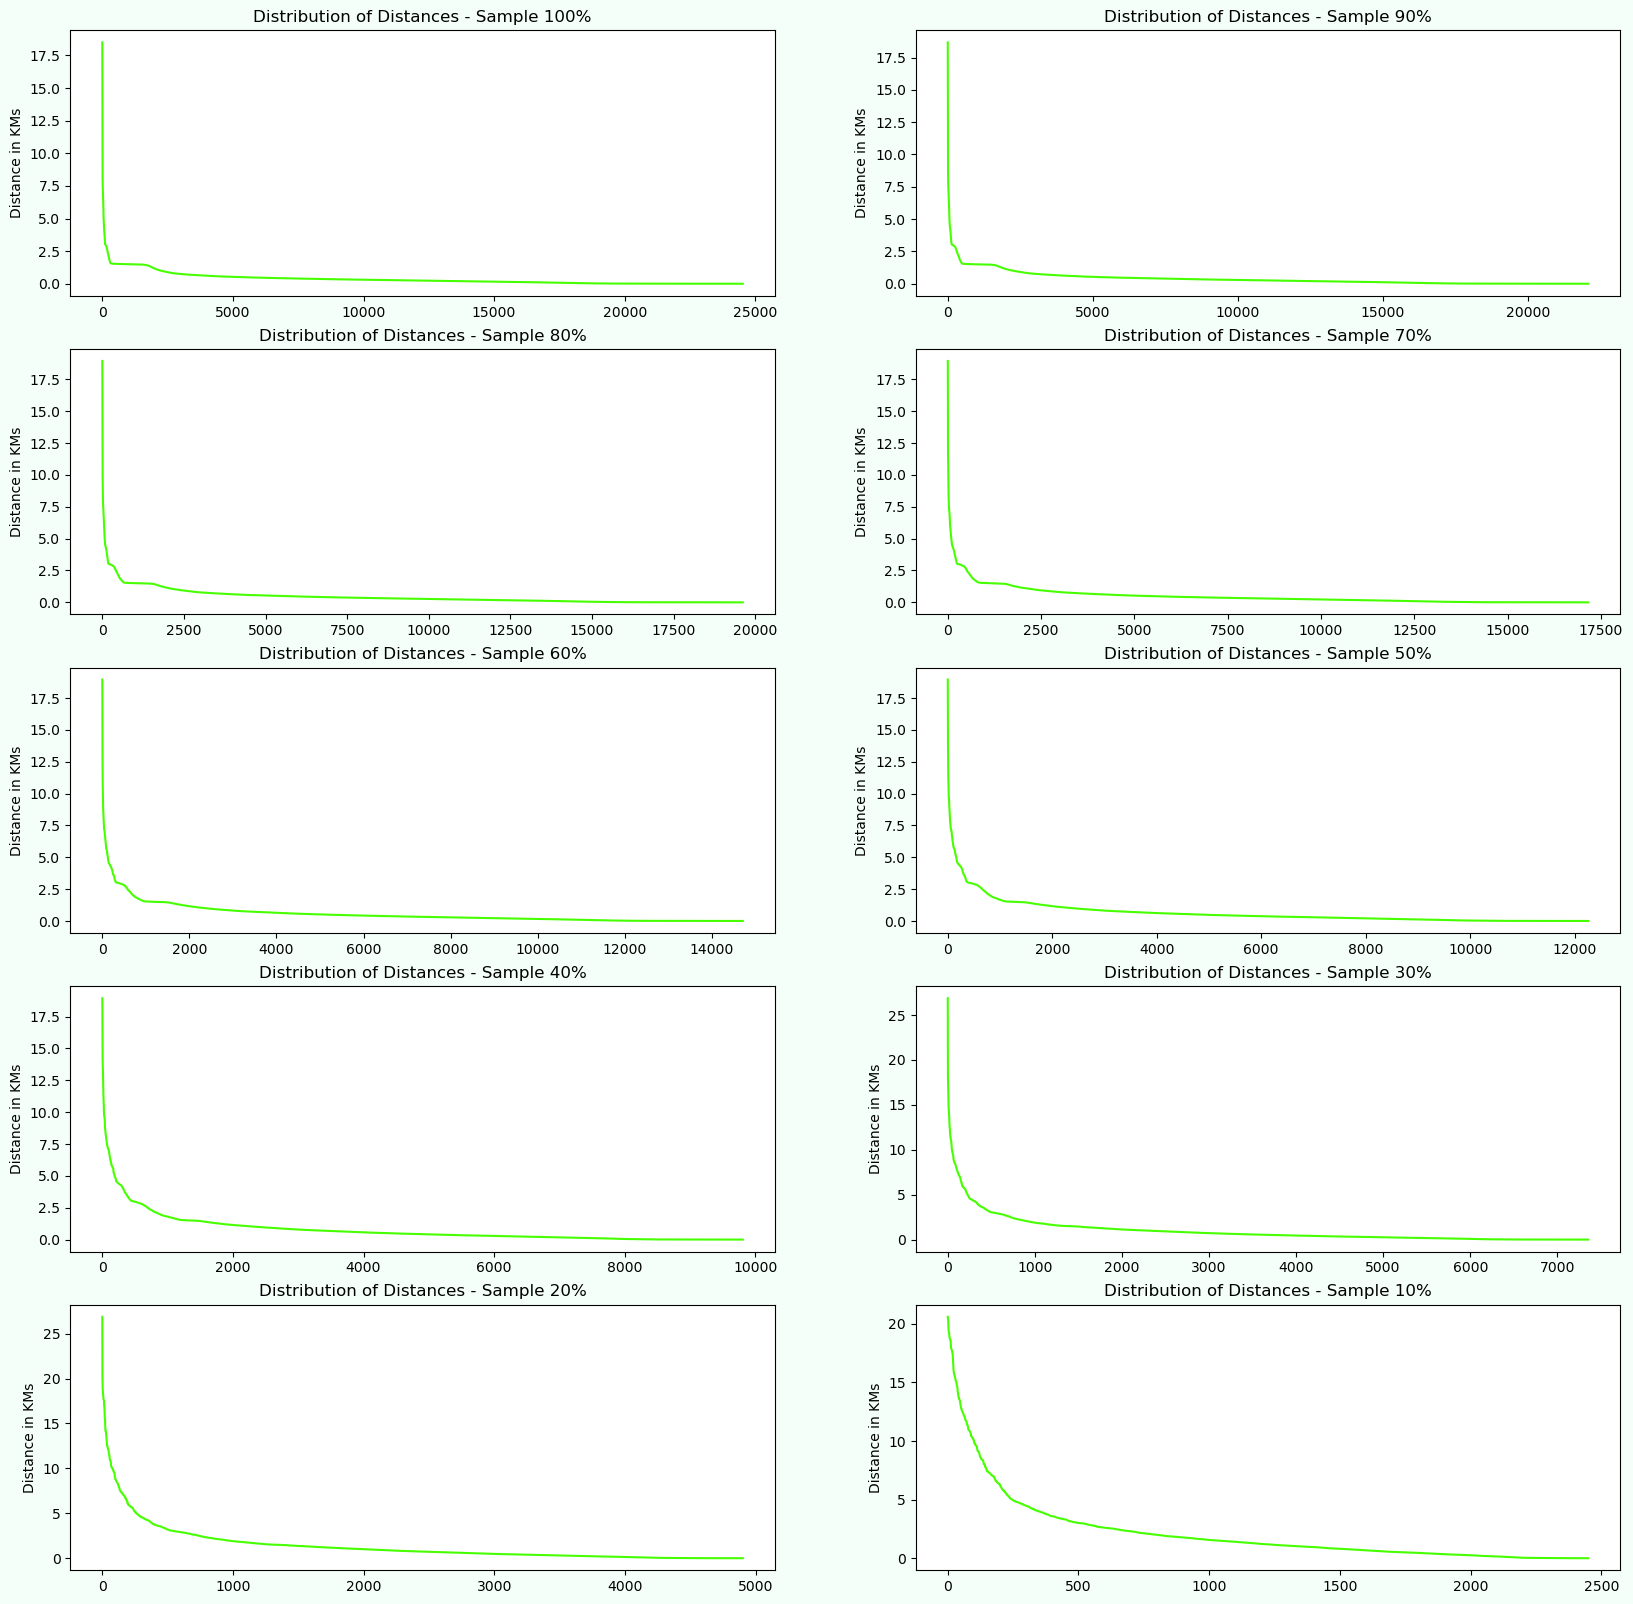

In [127]:
plot = driver_plots(taxi_10,drivers[7])

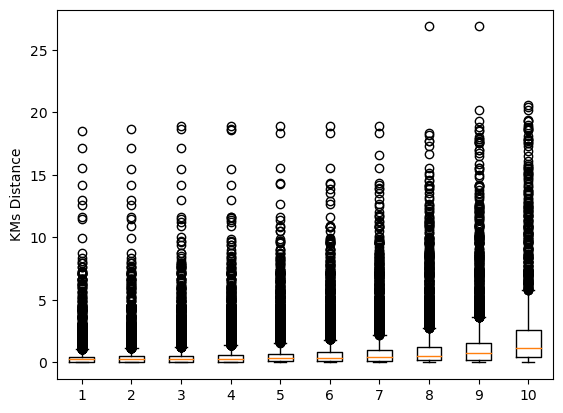

In [128]:
# Boxplots from 100% to 10% samples
plt.boxplot(plot)
plt.ylabel("KMs Distance")
plt.show()

# Ninth UID Distributions Plot and Box Plot

In [129]:
print(f"Taxi Driver: \t{drivers[8]}")
dist = len(taxi_10[taxi_10["uid"] == drivers[8]])
print(f"N° of rows: \t{dist}")

Taxi Driver: 	abwecnij
N° of rows: 	25627


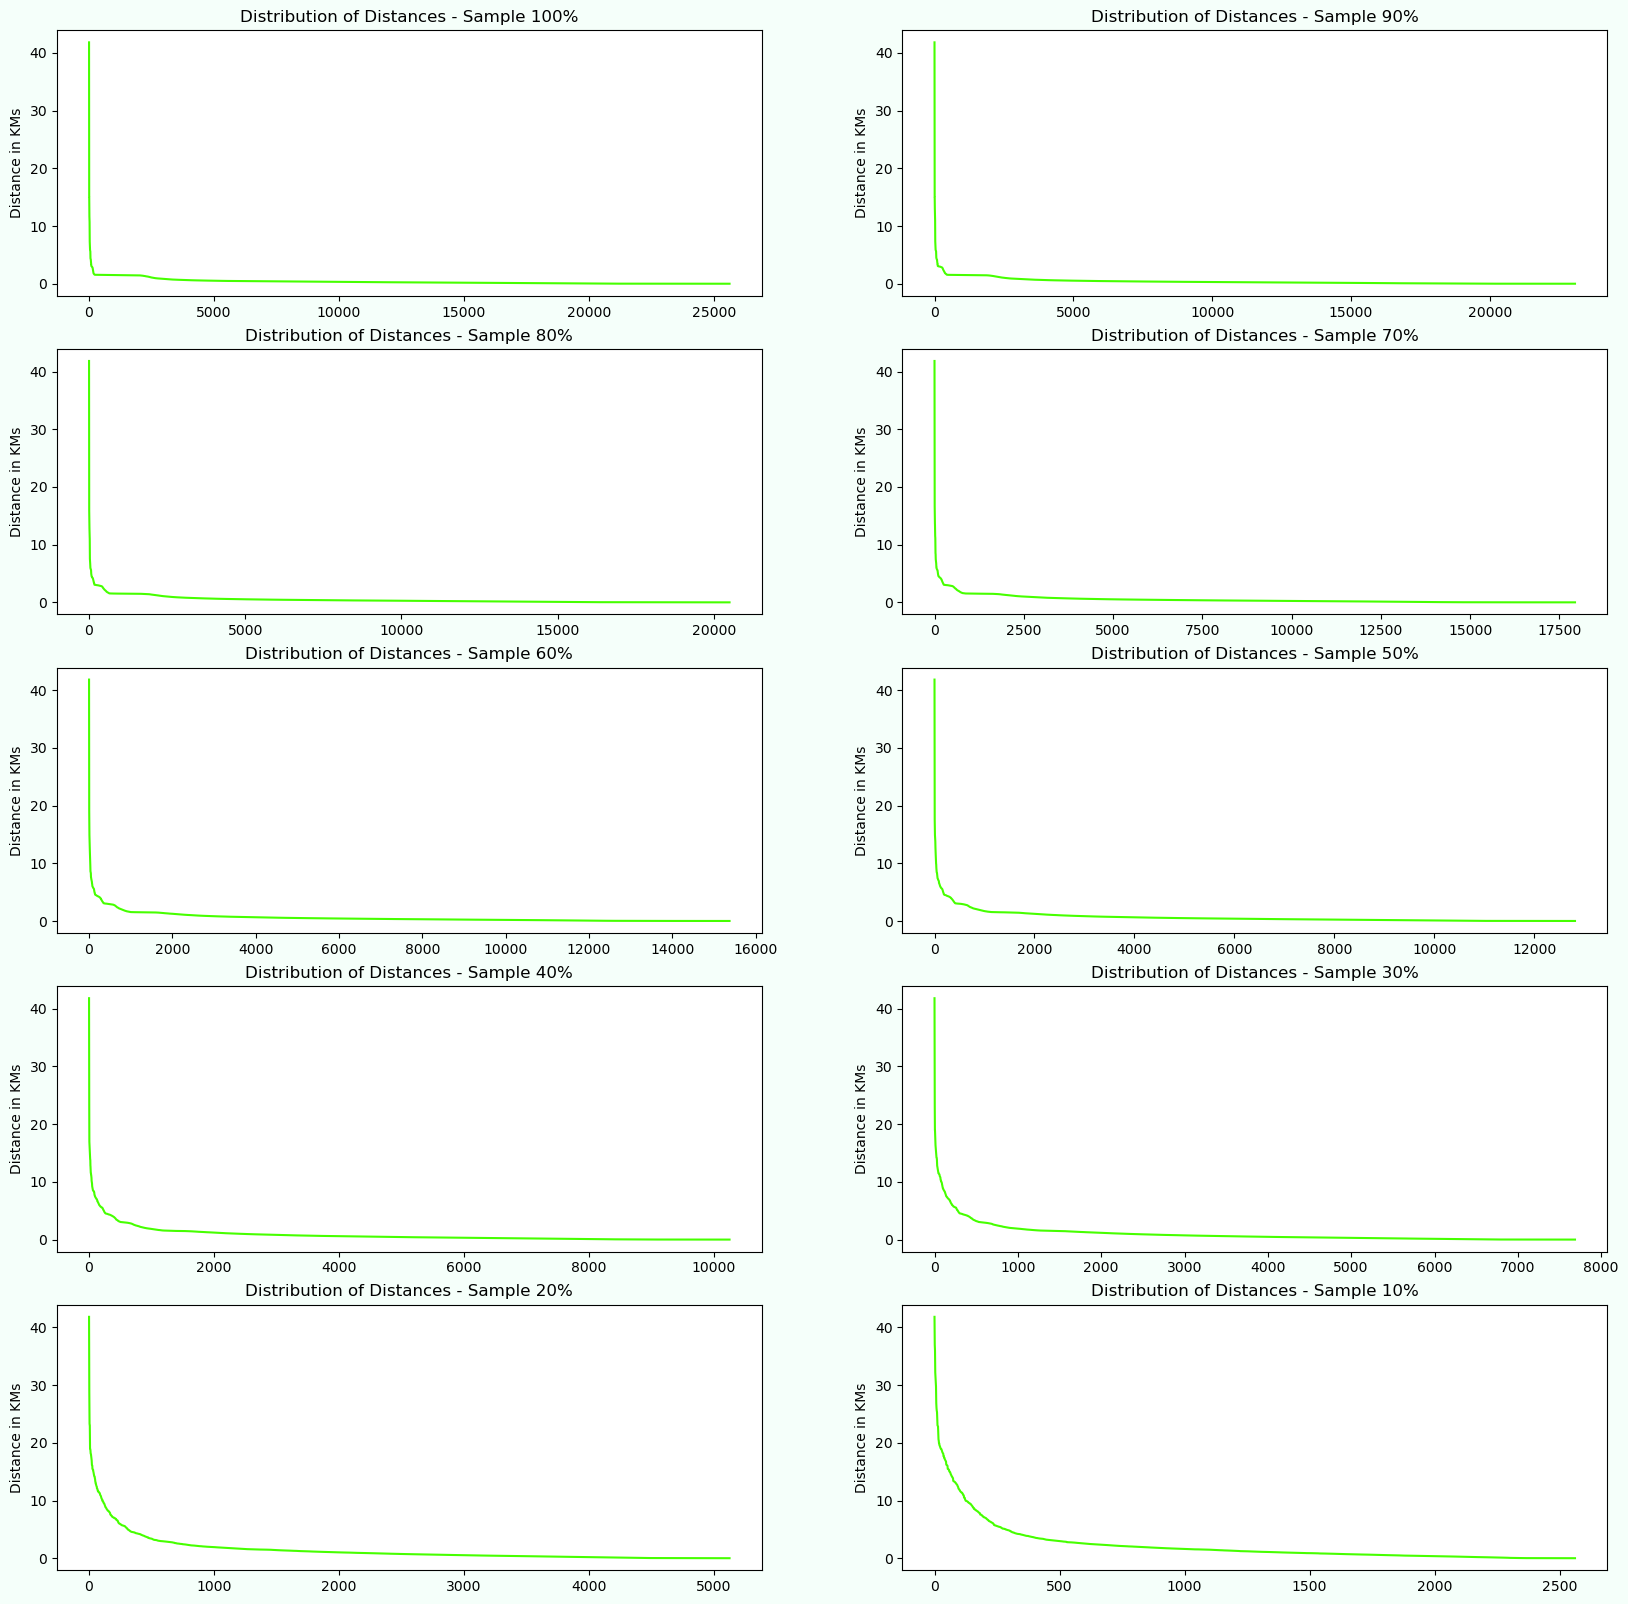

In [130]:
plot = driver_plots(taxi_10,drivers[8])

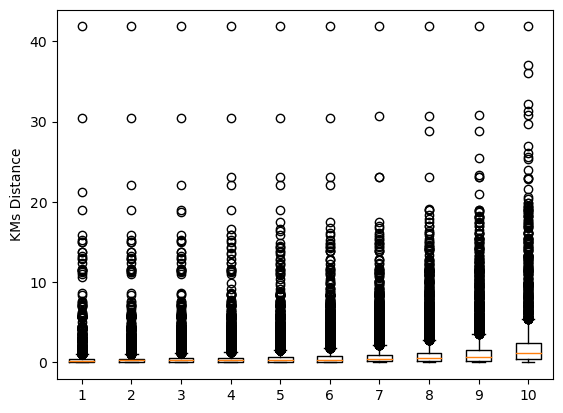

In [131]:
# Boxplots from 100% to 10% samples
plt.boxplot(plot)
plt.ylabel("KMs Distance")
plt.show()

# Tenth UID Distributions Plot and Box Plot

In [132]:
print(f"Taxi Driver: \t{drivers[9]}")
dist = len(taxi_10[taxi_10["uid"] == drivers[9]])
print(f"N° of rows: \t{dist}")

Taxi Driver: 	icagpony
N° of rows: 	25410


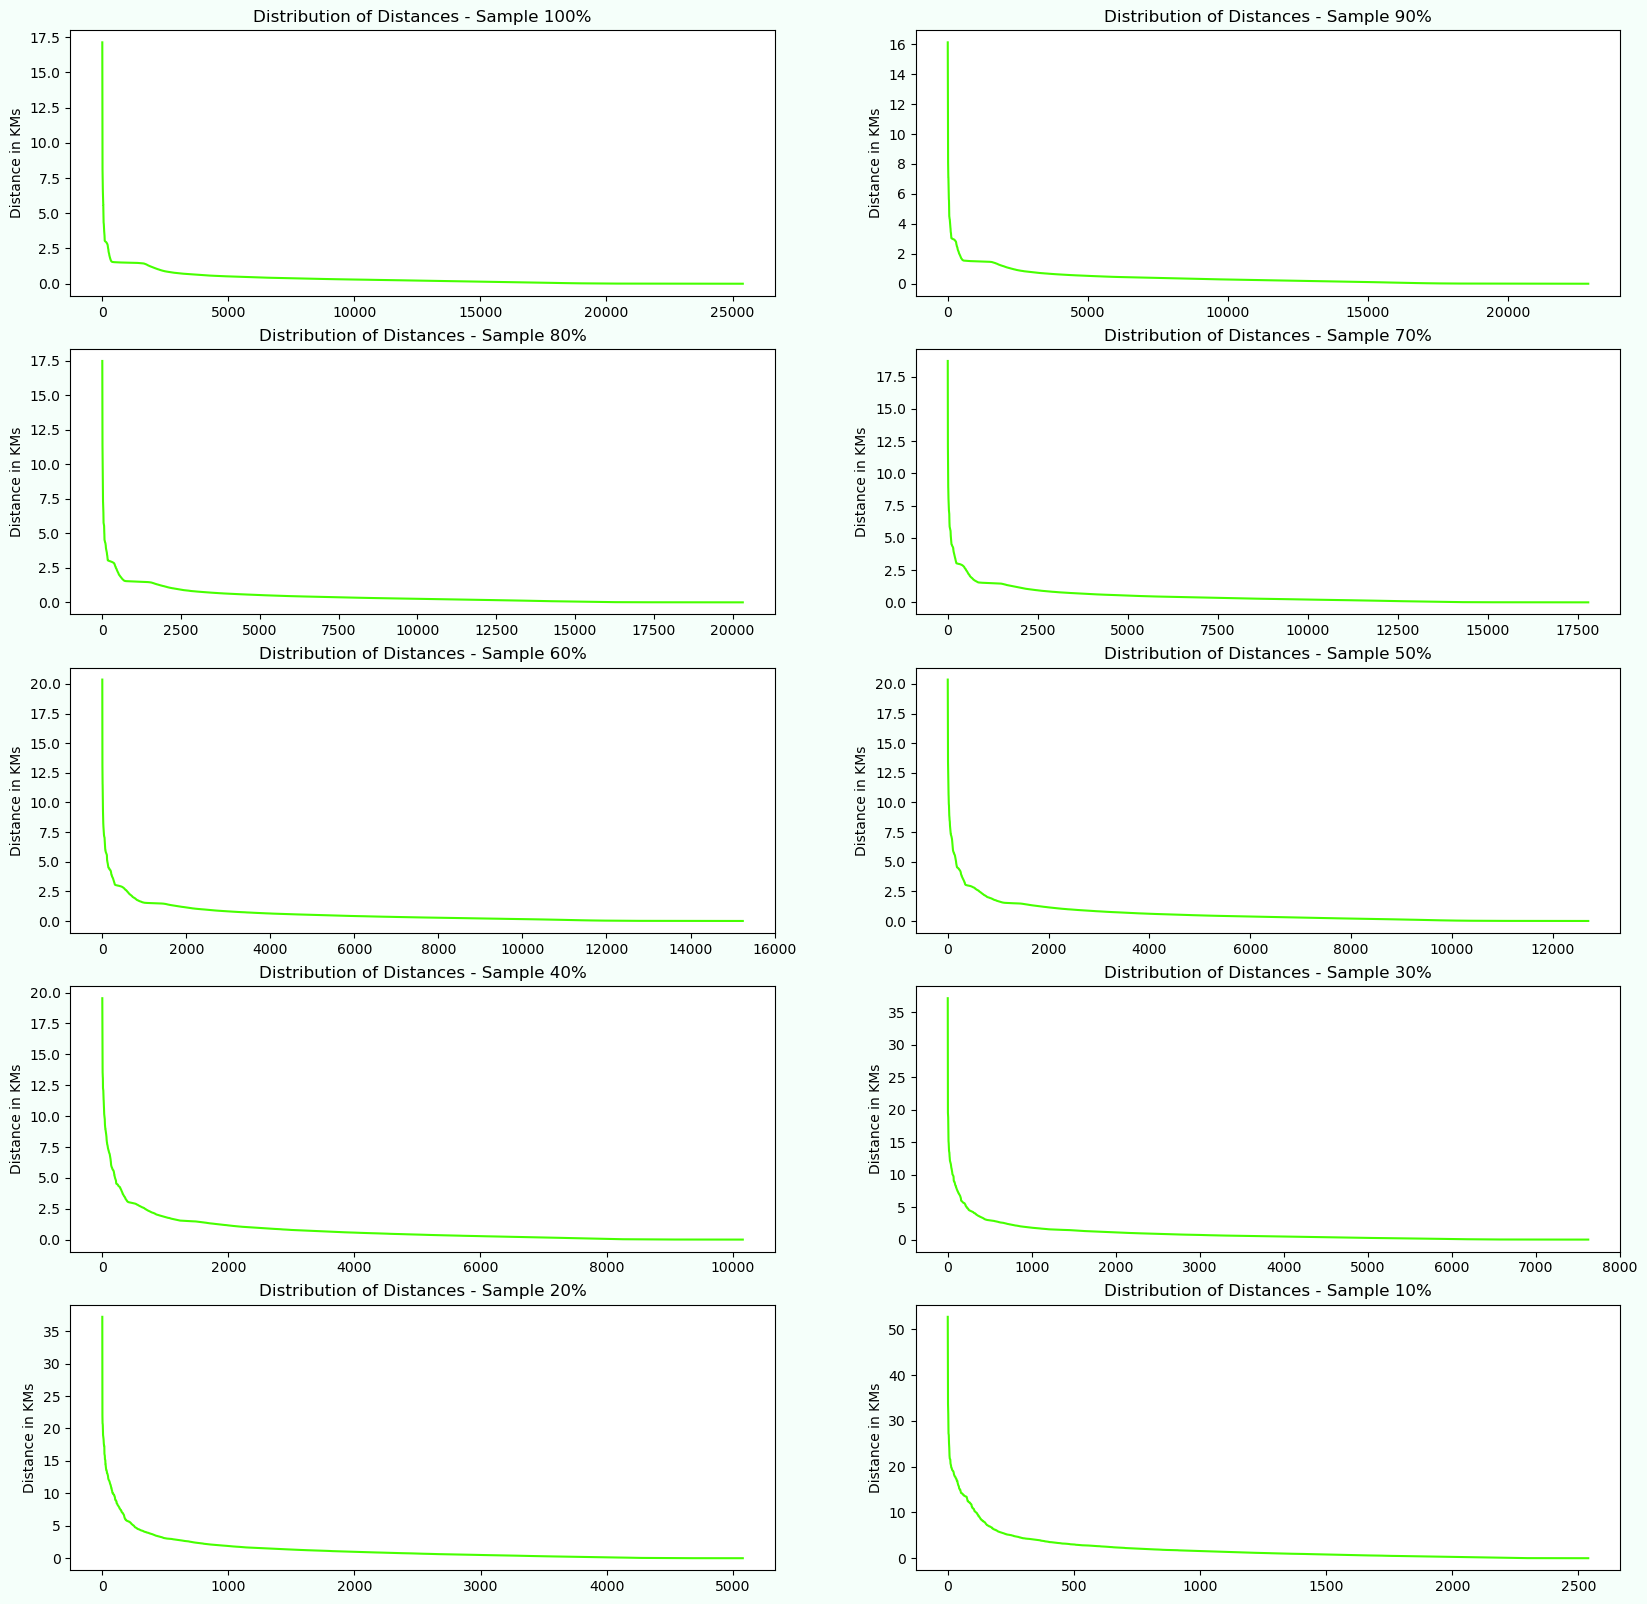

In [133]:
plot = driver_plots(taxi_10,drivers[9])

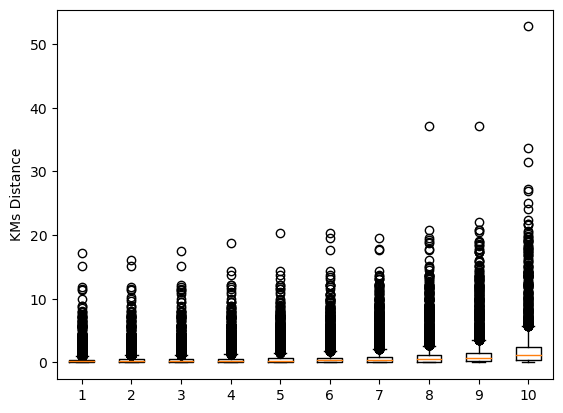

In [134]:
# Boxplots from 100% to 10% samples
plt.boxplot(plot)
plt.ylabel("KMs Distance")
plt.show()

# Conclusions

By looking at the distributions of each taxi driver it is clear that if we sample the Trajectory DF by 10%,20%.. up to 90% the distribution tends not to change drastically.

Instead, the **Heavily Tailed - Power Law distribution** is mostly kept the same by the whole process but as it is possible to check in the green distribution plots they tend to be more elastic by adding longer distances and decreasing smaller ones, developing a kind of a "belly".

Also, few aspects that must be taken into account:

 - **Medians** of distances are kept low, as the most travels regards small trajectories in the crowded area of San Francisco, but they keep increasing. 

- **Interquartile Ranges** gets bigger the more the points are filtered; this is probably due to fact that by cutting of points in the middle of a trajectory, trips tend to grow longer as closer points are eliminated

- A proportional amount of **outliers** are mantained in the distributions but more "extreme" ones are eventually generated the smaller the sample because new long trips are created and taken into account.